In [1]:
import os
import re
from typing import Dict

import mne
import numpy as np
import scipy.stats as sp_stats
from joblib import Parallel, delayed
from NirsLabProject.config.paths import Paths

from NirsLabProject.utils import pipeline_utils as putils
from NirsLabProject.config.consts import *

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.utils import pipeline_utils
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils.group_spikes import group_spikes
from NirsLabProject.utils import plotting

In [2]:
subjects = putils.get_subjects(
    filters=[
        lambda subj: os.path.exists(subj.paths.subject_flat_features_path),
        lambda subj: str(subj.p_number) in ['396', '398', '402', '406', '415', '416', '485', '487', '489', '498', '499', '520'],
    ],
    sort_key=lambda subj: subj.p_number,
)
print(f"Found {len(subjects)} subjects")

Found 12 subjects


In [3]:
import pandas as pd
import netplotbrain
import matplotlib.pyplot as plt
import webcolors
import matplotlib.colors as mcolors
import seaborn as sns

def polot_coordinates_prevalence_colore_based(x : list, y : list, z : list, values : list):
    color_palette = generate_color_gradient(values)
    colors = {val: get_colour_name(color) for val, color in color_palette.items()}
    colors = [colors[val] for val in values]

    data = pd.DataFrame(
        data = {
            'x': x,
            'y': y,
            'z': z,
            'color': colors
        }
    )

    fig, ax = netplotbrain.plot(
        template='MNI152NLin2009cAsym',
        nodes=data,
        node_color='color',
        node_scale=10,
        view='preset-6',
        dpi=800,
    )

    palette = sns.color_palette("vlag", len(values))
    palette = reversed(palette)
    cmap = sns.blend_palette(palette, as_cmap=True)

    # Plotting a color bar with the seaborn color palette
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.5)
    # setting the color bar ticks and labels
    values = list(color_palette.keys())
    cbar.set_ticks(np.linspace(0, 1, 2))  # Set ticks to match the colors
    cbar.set_ticklabels([ min(values), max(values)])  # Set custom tick labels
    # save with high resolution to avoid pixelation
    plt.savefig('coordinates_prevalence_colore_based.svg', dpi=800, )
    plt.show()

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(color):
    requested_colour = (int(color[0]*256), int(color[1]*256), int(color[2]*256))
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return closest_name

def generate_color_gradient(values: list) -> dict:
    palette = sns.color_palette("coolwarm", len(values))
    return {value: color for value, color in zip(values, palette)}

In [4]:
def polot_coordinates_prevalence_size_based(x : list, y : list, z : list, values : list):
    # normlize the values to be between 0 and 10
    # values = [((val - min(values)) / (max(values) - min(values))) * 10 for val in values]

    data = pd.DataFrame(
        data = {
            'x': x,
            'y': y,
            'z': z,
            'size': values
        }
    )

    fig, ax = netplotbrain.plot(
        template='MNI152NLin2009cAsym',
        nodes=data,
        node_size='size',
        node_scale=20,
        view='preset-6',
        dpi=800,
    )

    plt.savefig('coordinates_prevalence_size_based.svg', dpi=800, format='svg')
    plt.show()

no coordinates file found, calculating coordinates from average coordinates files
Skipping 415 - no coordinates file found
Skipping 416 - no coordinates file found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found
Skipping 489 - micro channel found


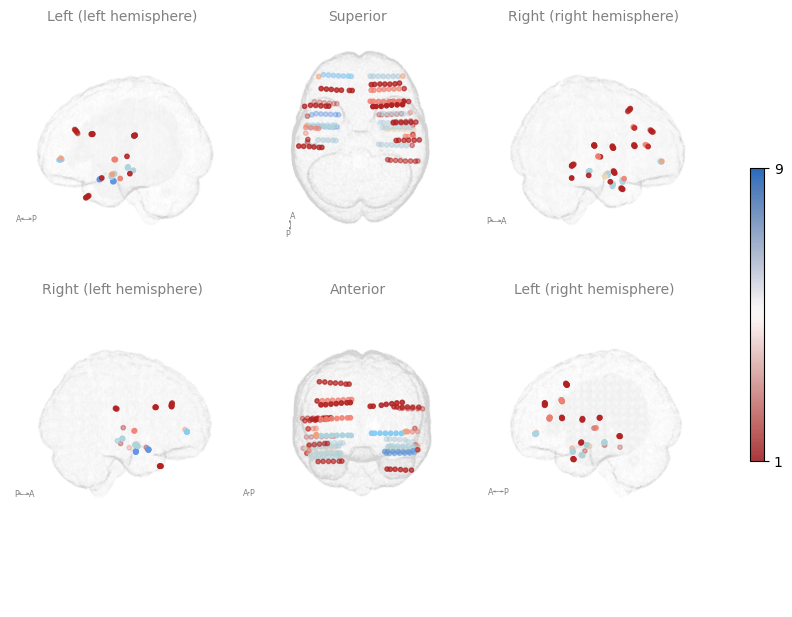

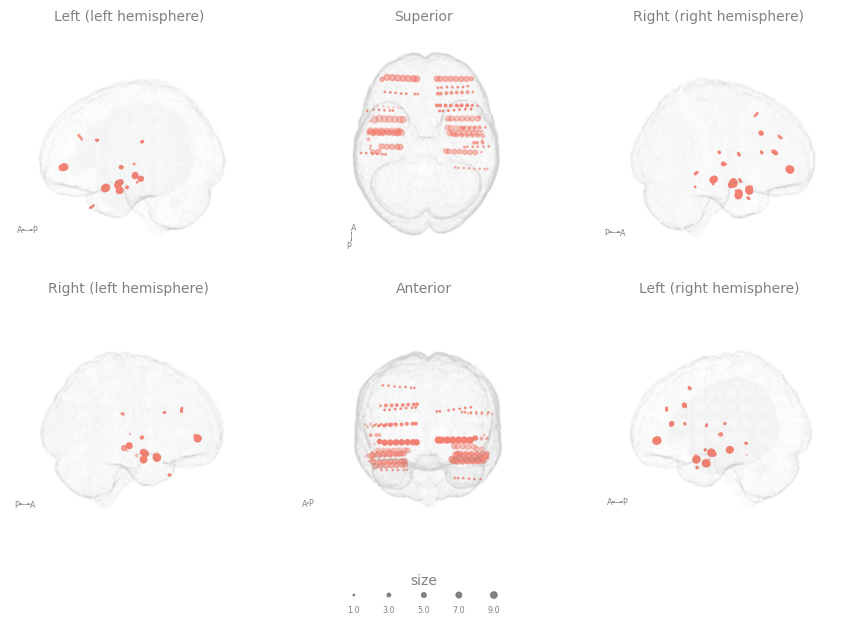

In [5]:
def get_chanels_prevalence():
    channels_counter = {}
    for subject in subjects:   
        coordinates_file = subject.paths.subject_electrode_name_file
        if not os.path.exists(coordinates_file):
            print(f"Skipping {subject.p_number} - no coordinates file found")
            continue
        channel_names = pd.read_csv(
            filepath_or_buffer=coordinates_file,
            delimiter=' ',
            usecols=[0],
            skiprows=2,
            header=None,
            dtype={0: str}
        )
        for channel_name in channel_names[0]:
            if 'micro' in channel_name:
                print(f"Skipping {subject.p_number} - micro channel found")
                continue
            if subject.sourasky_project:
                channel_name = utils.foramt_sourasky_patients_channel_names(channel_name)
            if channel_name not in channels_counter:
                channels_counter[channel_name] = 0
            channels_counter[channel_name] += 1
    

    return {name: prevalence for name, prevalence in channels_counter.items() if not name.startswith('RTT')}

all_coords = utils.calculate_coordinates(None, True)
sourasky_cords  = utils.calculate_coordinates_sourasky_avrage()
features = {}
no_cords = {}
for channel_name, prevalence in get_chanels_prevalence().items():
    channel_coords = all_coords.get(channel_name, None)
    if channel_coords:
        features[channel_name] = {
            'value' : prevalence,
            'cords' : channel_coords
        }
    else:
        if channel_name in sourasky_cords:
            features[channel_name] = {
                'value' : prevalence,
                'cords' : sourasky_cords[channel_name]
            }        
        else:
            no_cords[channel_name] = prevalence     

x = [x['cords'][0] for x in features.values()]
y = [x['cords'][1] for x in features.values()]
z = [x['cords'][2] for x in features.values()]
values = [x['value'] for x in features.values()]

# save prevalence values to a csv file
df = pd.DataFrame(features).T
df.reset_index(inplace=True)
df.columns = ['channel', 'prevalence', 'cords']
df.to_csv('prevalence.csv', index=False)

polot_coordinates_prevalence_colore_based(x, y, z, values)
polot_coordinates_prevalence_size_based(x, y, z, values)



view = plotting.plot_feature_on_electrodes(Subject('p1', True), features, 'Prevalence of channels', marker_size=8)
view.open_in_browser()

In [87]:
import mne 

for subj in ['p3', 'p406']:
    channels = []
    subject = Subject(subj, True)
    raw = mne.io.read_raw_edf(subject.paths.subject_raw_edf_path)
    raw = utils.pick_seeg_and_eog_channels(raw)
    utils.clean_channels_name_in_raw_obj(subject, raw)
    channels.extend(raw.ch_names)
    with open(f'{subject.p_number}.electrodeNames', 'w') as file:
        for channel in channels:
            file.write(f"{channel} X X\n")

        

Picking SEEG and EOG channels
Cleaning channels names
Picking SEEG and EOG channels
Cleaning channels names
